# Grokking
Can we observe grokking on modular addition in a toy example?

## setup

In [294]:
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [295]:
# hyperparameters
split = 0.3
n_vocab = 53
n_embed = 200
n_hidden = 32
epoch = 40000
print_every = 1000
learning_rate = 1e-3
weight_decay = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [296]:
# make a training set
random.seed(0xdeadbeef) # reproducibility
X = [(i, j) for i in range(n_vocab) for j in range(n_vocab)]
random.shuffle(X)

X_train = X[: int(len(X) * split)]
X_test = X[int(len(X) * split):]
Y_train = [(i + j) % n_vocab for i, j in X_train]
Y_test = [(i + j) % n_vocab for i, j in X_test]

In [297]:
# train on full batch
def get_batch(name='train'):
    return {
        'train': (torch.tensor(X_train).to(device), torch.tensor(Y_train).to(device)),
        'test': (torch.tensor(X_test).to(device), torch.tensor(Y_test).to(device))
    }[name]

## model

In [298]:
torch.manual_seed(0xdeadbeef) # reproducibility

class NN(nn.Module):
    def __init__(self):
        super().__init__()

        self.embed = nn.Embedding(n_vocab, n_embed)
        self.layers = nn.Sequential(
            nn.Linear(n_embed, n_hidden),
            nn.ReLU(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(n_hidden),
            nn.Linear(n_hidden, n_vocab))

    def forward(self, x):
        a, b = x[:, 0], x[:, 1]
        # compute embedding
        a_embed = self.embed(a)
        b_embed = self.embed(b)
        # merge them (could have been a torch.cat() instead?)
        embd = a_embed + b_embed
        return self.layers(embd)
    
model = NN().to(device)

## train

In [299]:
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def eval_weights():
    params = torch.cat([t.view(-1) for t in model.parameters()])
    weights = params.abs().sum()
    squared_weights = params.pow(2).sum()
    return weights, squared_weights

def evaluate(name):
    X, Y = get_batch(name)
    Y_hat = model(X)
    loss = F.cross_entropy(Y_hat, F.one_hot(Y, n_vocab).float())
    accuracy = (Y_hat.argmax(dim=1) == Y).float().mean()
    return loss, accuracy

@torch.no_grad()
def evaluate_test():
    return evaluate('test')

def evaluate_train():
    return evaluate('train')

# metrics
losses, test_losses = [], []
accuracies, test_accuracies = [], []
weights, squared_weights = [], []

# training loop
for i in tqdm(range(epoch)):
    loss, accuracy = evaluate_train()
    test_loss, test_accuracy = evaluate_test()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # collect metrics
    losses.append(loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    test_accuracies.append(test_accuracy)
    w, sw = eval_weights()
    weights.append(w)
    squared_weights.append(sw)

    # progress
    if i % print_every == print_every - 1:
        print(f'epoch: {i: 6} loss: {loss.item():.7f} test_loss: {test_loss:.7f}')

  0%|          | 0/40000 [00:00<?, ?it/s]

epoch:    999 loss: 0.0502835 test_loss: 10.5064898
epoch:   1999 loss: 0.0242057 test_loss: 10.3605604
epoch:   2999 loss: 0.0133680 test_loss: 10.2988358
epoch:   3999 loss: 0.0078245 test_loss: 10.3771477
epoch:   4999 loss: 0.0047008 test_loss: 10.1779966
epoch:   5999 loss: 0.0028200 test_loss: 9.4941788
epoch:   6999 loss: 0.0016826 test_loss: 8.4823513
epoch:   7999 loss: 0.0010103 test_loss: 7.3390369
epoch:   8999 loss: 0.0005924 test_loss: 5.8882031
epoch:   9999 loss: 0.0003519 test_loss: 4.6133909
epoch:  10999 loss: 0.0002138 test_loss: 3.8075659
epoch:  11999 loss: 0.0001278 test_loss: 3.0056672
epoch:  12999 loss: 0.0000773 test_loss: 2.4346497
epoch:  13999 loss: 0.0000467 test_loss: 1.9957902
epoch:  14999 loss: 0.0000285 test_loss: 1.6337124
epoch:  15999 loss: 0.0000157 test_loss: 0.5343108
epoch:  16999 loss: 0.0000091 test_loss: 0.0578192
epoch:  17999 loss: 0.0000055 test_loss: 0.0073123
epoch:  18999 loss: 0.0000033 test_loss: 0.0000632
epoch:  19999 loss: 0.0000

## Visualize train vs test

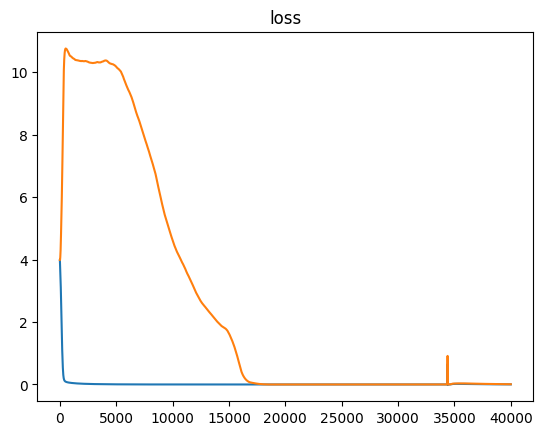

In [300]:
xs = torch.arange(epoch)

plt.title('loss')
plt.plot(xs, torch.tensor(losses).tolist(), label='train')
_ = plt.plot(xs, torch.tensor(test_losses).tolist(), label='test')

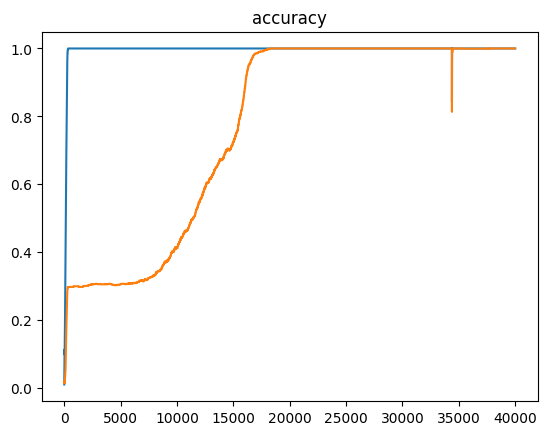

In [301]:
plt.title('accuracy')
plt.plot(xs, torch.tensor(accuracies).tolist(), label='train')
_ = plt.plot(xs, torch.tensor(test_accuracies).tolist(), label='test')

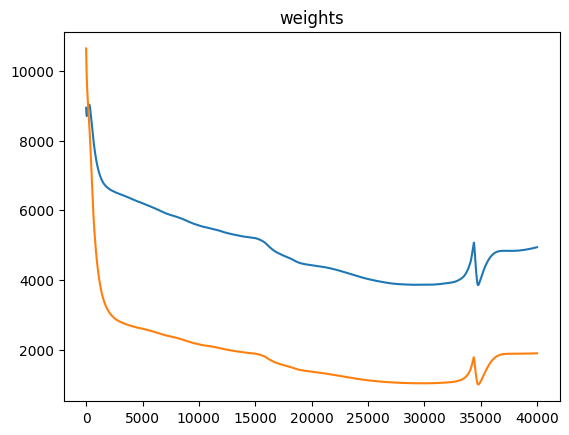

In [302]:
plt.title('weights')
plt.plot(xs, torch.tensor(weights).tolist(), label='weights')
_ = plt.plot(xs, torch.tensor(squared_weights).tolist(), label='squared_weights')

## use the model for prediction

In [303]:
model(torch.tensor([[2, 3], [3, 4], [33, 48]]).to(device)).argmax(dim=-1)

tensor([ 5,  7, 28], device='cuda:0')